In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import sys

sys.path.insert(0, "./../")
from FileManager import FileManager
import utils
utils.rcsetup()

In [3]:
VOCAB_SZ = 10_000

data_dir = os.path.join(os.getenv("DATASETPATH"), "qwem")
data_fm = FileManager(data_dir)

analogy_dict = data_fm.load("analogies.pickle")
if analogy_dict is None:
    raise FileNotFoundError("Analogy file not found.")

data_fm.set_filepath("enwiki500")
word_counts = data_fm.load("word_counts.pickle")

vocab = utils.Vocabulary(word_counts[:VOCAB_SZ])
unigram = vocab.counts / vocab.counts.sum()
analogy_dataset = utils.AnalogyDataset(analogy_dict, vocab)

data_fm.set_filepath(f"enwiki500/REC-eigh-V{VOCAB_SZ//1000}k")
eigvecs = data_fm.load("eigvecs.npy")
eigvals = data_fm.load("eigvals.npy")
data_fm.set_filepath(f"enwiki500")
if eigvecs is None or eigvals is None:
    raise FileNotFoundError("Run mstar_eigh.ipynb first.")

In [4]:
# EMBEDDIM = 200
# topd_eigvals, topd_eigvecs = eigvals[:EMBEDDIM], eigvecs[:, :EMBEDDIM]
# topd_Mstar = topd_eigvecs @ np.diag(topd_eigvals) @ topd_eigvecs.T
# W_QWEM = topd_eigvecs @ np.diag(np.sqrt(topd_eigvals))

# print(f"shape(W) = {W_QWEM.shape}")
# print(f"QWEM acc: {100*analogy_dataset.eval_accuracy(W_QWEM):.1f}%")

In [5]:
category2name = {
    "capital-common-countries": "country-capital",
    "capital-world": "country-capital-2",
    "currency": "country-currency",
    "city-in-state": "city-state",
    "family": "male-female",
    "gram1-adjective-to-adverb": "adj-adverb",
    "gram2-opposite": "adj-antonym",
    "gram3-comparative": "adj-comparative",
    "gram4-superlative": "adj-superlative",
    "gram5-present-participle": "verb-participle",
    "gram6-nationality-adjective": "country-nationality",
    "gram7-past-tense": "verb-preterite",
    "gram8-plural": "noun-plural",
    "gram9-plural-verbs": "verb-plural"
}
catname2category = {v:k for k,v in category2name.items()}

for category, category_analogies in analogy_dataset.analogies.items():
    if category != "full":
        npairs = len(analogy_dataset.pairs[category])
        print(f"{category2name[category]:<25} {npairs:>2} pairs\t {len(category_analogies):>4} analogies")
    else:
        print(f"Total: {len(category_analogies)} analogies")
print()


country-capital           19 pairs	  342 analogies
country-capital-2         38 pairs	 1406 analogies
country-currency           6 pairs	   30 analogies
city-state                39 pairs	 1482 analogies
male-female               16 pairs	  240 analogies
adj-adverb                18 pairs	  306 analogies
adj-antonym                6 pairs	   30 analogies
adj-comparative           21 pairs	  420 analogies
adj-superlative           14 pairs	  182 analogies
verb-participle           23 pairs	  506 analogies
country-nationality       35 pairs	 1190 analogies
verb-preterite            27 pairs	  702 analogies
noun-plural               23 pairs	  506 analogies
verb-plural               17 pairs	  272 analogies
Total: 7614 analogies



In [47]:
def analogy_score(analogy_dataset, W, category="full"):
    normalizer = np.maximum(np.linalg.norm(W, axis=1, keepdims=True), 1e-12)
    embeds = W / normalizer
    analogies = analogy_dataset.analogies[category]
    w1 = embeds[analogies[:, 0]]
    w2 = embeds[analogies[:, 1]]
    w3 = embeds[analogies[:, 2]]
    guess = (w3 + w2 - w1).T
    guess /= np.linalg.norm(guess, axis=0, keepdims=True)
    pred = embeds @ guess
    num = len(analogies)
    pred[analogies[:, 0], np.arange(num)] = -np.inf
    pred[analogies[:, 1], np.arange(num)] = -np.inf
    pred[analogies[:, 2], np.arange(num)] = -np.inf
    correct = (pred.argmax(axis=0) == analogies[:, 3]).astype(int)
    neighbors = embeds @ embeds[analogies[:, 3]].T
    neighbors[analogies[:, 0], np.arange(num)] = -np.inf
    neighbors[analogies[:, 1], np.arange(num)] = -np.inf
    neighbors[analogies[:, 2], np.arange(num)] = -np.inf
    neighbors[analogies[:, 3], np.arange(num)] = -np.inf
    return pred, pred[analogies[:, 3], np.arange(num)], neighbors, correct

In [58]:
families = [
    "country-nationality", "male-female", "verb-preterite",
    "adj-adverb", "adj-antonym", 
]
dd = np.logspace(2, 12, 21, base=2).astype(int)


scores = {}
normscores = {}
for fam in tqdm(families):
    category = catname2category[fam]
    scores[fam] = []
    normscores[fam] = []
    correct_mask = slice(None)
    # for d in dd:
    #     W = eigvecs[:, :d] @ np.diag(np.sqrt(eigvals[:d]))
    #     _, pred, neighbors, correct = analogy_score(analogy_dataset, W, category=category)
    #     correct_mask = correct if correct_mask is None else correct_mask & correct
    for d in dd:
        W = eigvecs[:, :d] @ np.diag(np.sqrt(eigvals[:d]))
        _, pred, neighbors, correct = analogy_score(analogy_dataset, W, category=category)
        score = pred[correct_mask].mean()
        normscore = (pred / neighbors.max(axis=0))[correct_mask].mean()
        scores[fam].append(score)
        normscores[fam].append(normscore)

100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


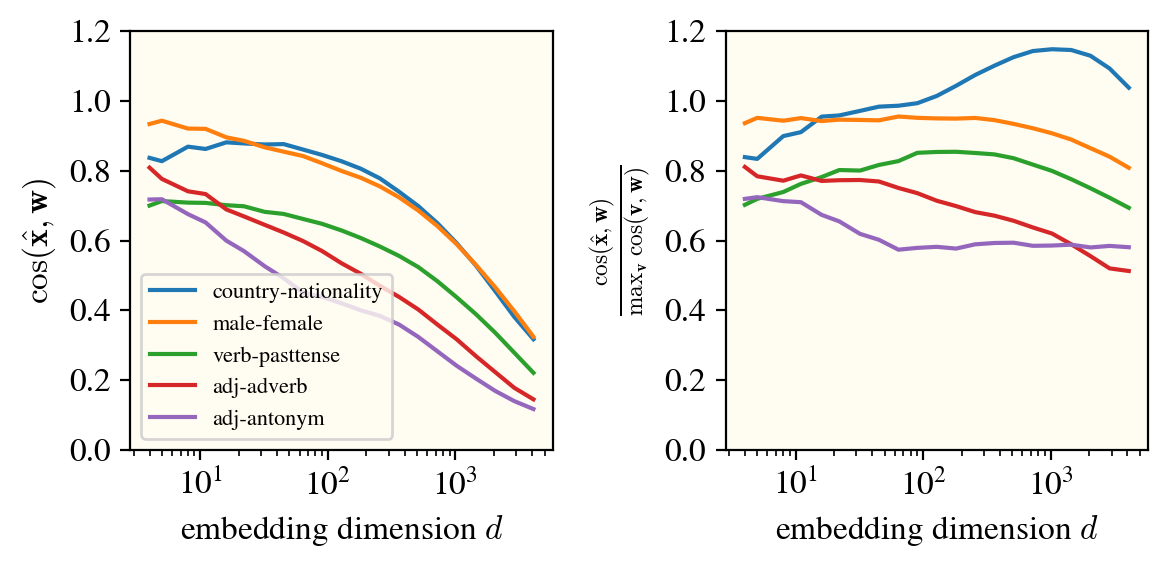

In [69]:
fig, axes = plt.subplots(ncols=2, figsize=(6,3), dpi=200)

ax1, ax2 = axes
for fam in families:
    label = fam if fam!="verb-preterite" else "verb-pasttense"
    ax1.plot(dd, scores[fam], label=label)
    ax2.plot(dd, normscores[fam], label=label)

score_str = f"\\cos(\\hat \\mathbf{{x}}, \\mathbf{{w}})"
norm_str = f"\\mathrm{{max}}_\\mathbf{{v}} \\; \\cos(\\mathbf{{v}}, \\mathbf{{w}})"

ax1.set_xscale("log")
ax1.set_ylim(0, 1.2)
ax1.set_xlabel(f"embedding dimension $d$")
ax1.set_ylabel(f"${{{score_str}}}$")
ax1.legend(fontsize=8, loc='lower left', bbox_to_anchor=(0, 0))

ax2.set_xscale("log")
ax2.set_ylim(0, 1.2)
ax2.set_xlabel(f"embedding dimension $d$")
ax2.set_ylabel(f"$\\frac{{{score_str}}}{{{norm_str}}}$")

plt.tight_layout()
plt.savefig("./figures/appx-top1.pdf")
# plt.show()